## Main
### EPC400, manual with controller (or DAQ)
### fiber thermal delay with DAQ

In [29]:
%matplotlib inline

import os
import csv
import time
import psutil
import pyvisa
import random
import asyncio
import threading
import numpy as np
import pandas as pd
import nidaqmx as ni
from ctypes import *
from nidaqmx import constants
import ipywidgets as widgets
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.autolayout'] = True; plt.rc('font', size=16)
plt.rc('text', usetex=False); plt.rc('font', family='serif'); plt.rcParams['figure.figsize'] = (10, 5)

from Instruments.OzOptics import ozopticsEPC400 as EPC400 

## init params
resMan = pyvisa.ResourceManager()
outputMain = widgets.Output()

if len(resMan.list_resources()) > 1: 
    instAddress = list(resMan.list_resources())[0] ## ignore if nothing found, can "simulate" from personal laptop
instHandler = 'None'
polConControlBoxHandler, polConDAQ1AO0Handler, polConDAQ1AO1Handler, polConDAQ2AO0Handler, polConDAQ2AO1Handler = 'None', 'None', 'None', 'None', 'None',
connStatus = 'Idle'
polConDAQStatus = False
polConControlBoxAddr, polConDAQ1Addr, polConDAQ2Addr = 'ASRL6::INSTR', 'dev2', 'dev3'

## classes
class Stacks(list):
    def __init__(self, maxSize):
        super().__init__()
        self.maxSize = maxSize

    def init(self, element):
        for i in range(self.maxSize):
            self.append(element)

    def push(self, element):
        self.append(element)
    
    def append(self, element):
        super().append(element)
        if super().__len__() > self.maxSize:
            super().__delitem__(0)

## init widgets
scanButton = widgets.Button(description='Scan for Instruments'); 
checkConnectButton = widgets.Button(description='Check Connection')
connectInstMeasButton = widgets.Button(description='Connect'); 
stopMeasButton = widgets.Button(description='Stop & Disconnect')
instIDBox = widgets.Text(); 
dropdownBox = widgets.Dropdown(options=list(resMan.list_resources()), description='Address')

## scan and connect ###?????
scanConnectButtonHandler = widgets.HBox([scanButton, checkConnectButton])
instFindHandler = widgets.VBox([scanConnectButtonHandler, dropdownBox])
instStartHandler = widgets.VBox([instIDBox, widgets.HBox([connectInstMeasButton, stopMeasButton])])

## first accordion 
polConConnBox = widgets.Text(description='Polarization Controller Status', value='Not Connected', style={'description_width':'initial'})
polConConnButton = widgets.Button(description='Connect', style={'description_width':'initial'}); 
polConDAQButton = widgets.Button(description='Control Box', style={'description_width':'initial'})
polConAddr1Box = widgets.Text(description='Address1', value=polConControlBoxAddr, style={'description_width':'initial'}); 
polConAddr2Box = widgets.Text(description='Address2', value=polConDAQ2Addr, disabled=True, style={'description_width':'initial'})
v1Slider = widgets.FloatSlider(description='V1 [V]', value=0, min=-5, max=5, step=0.01, continuous_update=True, readout=True, disabled=True); 
v2Slider = widgets.FloatSlider(description='V2 [V]', value=0, min=-5, max=5, step=0.01, continuous_update=True, readout=True, disabled=True)
v3Slider = widgets.FloatSlider(description='V3 [V]', value=0, min=-5, max=5, step=0.01, continuous_update=True, readout=True, disabled=True); 
v4Slider = widgets.FloatSlider(description='V4 [V]', value=0, min=-5, max=5, step=0.01, continuous_update=True, readout=True, disabled=True)
polConLogBox = widgets.Textarea(layout=widgets.Layout(height='100px', width='100%'))

polConHandler = widgets.VBox([widgets.HBox([widgets.VBox([widgets.HBox([v1Slider]), widgets.HBox([v2Slider]), 
                                        widgets.HBox([v3Slider]), widgets.HBox([v4Slider])]),
                              widgets.HBox([widgets.VBox([polConConnBox, polConAddr1Box, polConAddr2Box]), 
                                            widgets.VBox([polConDAQButton, polConConnButton])])
                                          ]),
                            polConLogBox
                            ])

## second accordion 
thermalDelayConnBox = widgets.Text(description='Thermal Delay Status', value='Not Connected', style={'description_width':'initial'})
usbChanBox = widgets.IntText(description='USB Device Address [devX]', value=3, style={'description_width':'initial'}); setTempChanBox = widgets.IntText(description='Temperature Set Channel [/aoX]', value=1, style={'description_width':'initial'})
tempMonitorChanBox = widgets.IntText(description='Temperature Monitor Channel [/aiX]', value=2, style={'description_width':'initial'}); setMonitorChanBox = widgets.IntText(description='Set Monitor Channel [/aiX]', value=6, style={'description_width':'initial'})
enableChanBox = widgets.IntText(description='Enable Channel [/port0/lineX]', value=1, style={'description_width':'initial'}); thermalDelayConnButton = widgets.Button(description='Connect', style={'description_width':'initial'})
thermalDelayEnableButton = widgets.Button(description='Enable', style={'description_width':'initial'}, disabled=True)

setTempBox = widgets.BoundedFloatText(description='Temperature Set [°C]', value=45, min=41, max=114, step=0.001, style={'description_width':'initial'})
tempMonitorBox = widgets.Text(description='Current Temperature [°C]', value='0.000', style={'description_width':'initial'})
biasCurrentBox = widgets.Dropdown(description='Bias Current [A]', options=['10m', '1m', '100u', '10u'], value='100u', style={'description_width':'initial'})
thermalDelayLogBox = widgets.Textarea(layout=widgets.Layout(height='100px', width='100%'))
thermalDelayPlotBox = widgets.Output()

thermalDelayHandler = widgets.VBox([widgets.HBox([widgets.VBox([usbChanBox, setMonitorChanBox, tempMonitorChanBox, setTempChanBox, enableChanBox]),
                                    widgets.VBox([widgets.HBox([thermalDelayConnBox, thermalDelayConnButton]), 
                                                  widgets.HBox([biasCurrentBox, thermalDelayEnableButton]), 
                                                  setTempBox, tempMonitorBox])
                                                ]),
                                    thermalDelayLogBox, thermalDelayPlotBox
                                    ])

## all accordion
AccordHandler = widgets.Accordion(children=[polConHandler, thermalDelayHandler])
AccordHandler.set_title(0, 'Polarization Controller: EPC400')
AccordHandler.set_title(1, 'Fiber Thermal Delay: NI DAQ USB-6001')

## display widgets
display(
    widgets.VBox([widgets.Label('AdvancedInterconnect: Optimized for Fiber Control'),
        widgets.HBox([instFindHandler, instStartHandler]),
        AccordHandler]), 
    outputMain)

## functions & classes
def applyVoltFun(chan, volt):
    polConControlBoxHandler.setVoltage(chan, volt)
    
def logInBox(textbox, message):
    textbox.value = str(datetime.now()) + '   ' + message + '\n' + textbox.value

def parsePrefixStringToNumber(inputString):
    suffixes = { 'k': 1e3, 'M': 1e6, 'G': 1e9, 'T': 1e12, 'm': 1e-3, 'u': 1e-6, 'n': 1e-9, 'p': 1e-12,}

    suffix = inputString[-1]; multiplier = suffixes.get(suffix, 1)
    number = float(inputString[:-1]) if suffix in suffixes else float(inputString)
    return number*multiplier

def steinhartHartTemp(resistance):
        A = 7.41476049e-04; B = 2.11886252e-04; C = 1.11929889e-07 ## 100k
        return 1/(A + B*np.log(resistance) + C*(np.log(resistance))**3) ## temperature in K

def steinhartHartRes(temperature):
        A = 7.41476049e-04; B = 2.11886252e-04; C = 1.11929889e-07 ## 100k
        x = (A - (1/temperature))/C; y = np.sqrt((B/(3*C))**3 + ((x**2)/4))
        return np.exp(((y-(x/2))**(1/3)) - ((y+(x/2))**(1/3))) ## resistance in Ohm

## handlers
def scanButtonHandler(value):
    with outputMain:
        dropdownBox.options = list(resMan.list_resources())
        print(str(datetime.now()) + '   Scanning for instruments...')
scanButton.on_click(scanButtonHandler)

def dropdownBoxHandler(value):
    global instAddress

    if value['type'] == 'change' and value['name'] == 'value':
        with outputMain:
            instAddress = value['new']
            print(str(datetime.now()) + '   Selected device address: ' + instAddress)
dropdownBox.observe(dropdownBoxHandler)

def checkConnectButtonHandler(value):
    global instHandler, instAddress
    
    with outputMain:
        connectInstMeasButton.disabled = True
        print(str(datetime.now()) + '   Connecting to: ' + instAddress)
        instHandler = resMan.open_resource(instAddress)
        instIDBox.value = instHandler.query('*IDN?').strip()
        print(str(datetime.now()) + '   Connected to: ' + instIDBox.value)
        connectInstMeasButton.disabled = False
checkConnectButton.on_click(checkConnectButtonHandler)

def connectInstButtonHandler(value):
    global instHandler, polConControlBoxHandler

    with outputMain:
        if instIDBox.value != '':
                instHandler = resMan.open_resource(instAddress)
                print(str(datetime.now()) + '   Connection established to: ' + instIDBox.value); instIDBox.value = ''
        else:
            instIDBox.value = 'Check connection first!'
connectInstMeasButton.on_click(connectInstButtonHandler)

def stopMeasButtonHandler(value):
    global instHandler, polConControlBoxHandler

    with outputMain:
        print(str(datetime.now()) + '   Ending measurements...')
        instIDBox.value = ''
        instHandler = 'None'; polConControlBoxHandler = 'None'

        polConConnBox.value = 'Not Connected'
        print(str(datetime.now()) + '   Device(s) disconnected.')
        stopEvent.set()
        print(str(datetime.now()) + '   Everything is stopped. Rerun the file to start again.')
stopMeasButton.on_click(stopMeasButtonHandler)



def polConDAQButtonHandler(value):
    global polConDAQStatus
    if polConDAQStatus:
        logInBox(polConLogBox, 'Using control box...')
        polConAddr1Box.value = polConControlBoxAddr; polConAddr2Box.disabled = True 
        polConDAQStatus = False; polConDAQButton.description = 'Control Box'
    else:
        logInBox(polConLogBox, 'Using two NI DAQ USB-6001...')
        polConAddr1Box.value = polConDAQ1Addr; polConAddr2Box.disabled = False 
        polConDAQStatus = True; polConDAQButton.description = 'DAQ'
polConDAQButton.on_click(polConDAQButtonHandler)

def polConConnButtonHandler(value):
    global polConAddr, polConControlBoxHandler, polConDAQ1AO0Handler, polConDAQ1AO1Handler, polConDAQ2AO0Handler, polConDAQ2AO1Handler
    
    if polConConnBox.value == 'Not Connected':
        connStatus = 'Connecting'

        if polConDAQStatus: ## use DAQ
            v1Slider.value = 0; v2Slider.value = 0
            v3Slider.value = 0; v4Slider.value = 0
            polConAddr1Box.value, polConAddr2Box.value

            polConDAQ1AO0Handler = ni.Task; polConDAQ1AO1Handler = ni.Task; polConDAQ2AO0Handler = ni.Task; polConDAQ2AO1Handler = ni.Task
            polConDAQ1AO0Handler.ao_channels.add_ao_voltage_chan(polConAddr1Box.value+'/ao0', min_val=-5.5, max_val=5.5); polConDAQ1AO1Handler.ao_channels.add_ao_voltage_chan(polConAddr1Box.value+'/ao1', min_val=-5.5, max_val=5.5)
            polConDAQ2AO0Handler.ao_channels.add_ao_voltage_chan(polConAddr2Box.value+'/ao0', min_val=-5.5, max_val=5.5); polConDAQ2AO1Handler.ao_channels.add_ao_voltage_chan(polConAddr2Box.value+'/ao1', min_val=-5.5, max_val=5.5)
        else: 
            v1Slider.value = 0; v2Slider.value = 0
            v3Slider.value = 0; v4Slider.value = 0
            polConAddr = polConAddr1Box.value

            polConControlBoxHandler = EPC400(polConAddr)
            polConControlBoxHandler.setMode('DC')
            polConControlBoxHandler.setVoltages([0, 0, 0, 0])

        v1Slider.disabled = False; v2Slider.disabled = False
        v3Slider.disabled = False; v4Slider.disabled = False
        polConAddr1Box.disabled = True; polConAddr2Box.disabled = True; polConDAQButton.disabled = True

        instIDBox.value = 'EPC400 connected!'
        logInBox(polConLogBox, 'Connection established to EPC400 and voltages set to [0,0,0,0]...')
        polConConnBox.value = 'Connected'; polConConnButton.description = 'Disconnect'
        connStatus = 'Idle'
    else:
        connStatus = 'Disconnecting'

        if polConDAQStatus: ## use DAQ
            v1Slider.value = 0; v2Slider.value = 0
            v3Slider.value = 0; v4Slider.value = 0
            
            polConDAQ1AO0Handler.stop(); polConDAQ1AO0Handler.close()
            polConDAQ1AO1Handler.stop(); polConDAQ1AO1Handler.close()
            polConDAQ2AO0Handler.stop(); polConDAQ2AO0Handler.close()
            polConDAQ2AO1Handler.stop(); polConDAQ2AO1Handler.close()
        else: 
            v1Slider.value = 0; v2Slider.value = 0
            v3Slider.value = 0; v4Slider.value = 0

            polConControlBoxHandler.setVoltages([0, 0, 0, 0])
            polConControlBoxHandler.closeDevice()

        v1Slider.disabled = True; v2Slider.disabled = True
        v3Slider.disabled = True; v4Slider.disabled = True
        polConAddr1Box.disabled = False; polConAddr2Box.disabled = False; polConDAQButton.disabled = False

        instIDBox.value = 'EPC400 disconnected!'
        logInBox(polConLogBox, 'EPC400 disconnected successfully...')
        polConConnBox.value = 'Not Connected'; polConConnButton.description = 'Connect'
        connStatus = 'Idle'
polConConnButton.on_click(polConConnButtonHandler)



def thermalDelayConnButtonHandler(value):
    global setTempTask, tempMonitorTask, enableTask

    if thermalDelayConnBox.value == 'Not Connected':
        connStatus = 'Connecting'
        ## connect to NI DAQ
        setTempTask = ni.Task(); tempMonitorTask = ni.Task(); enableTask = ni.Task()
        setTempTask.ao_channels.add_ao_voltage_chan('dev'+str(usbChanBox.value)+'/ao'+str(setTempChanBox.value), min_val=-10, max_val=10)
        tempMonitorTask.ai_channels.add_ai_voltage_chan('dev'+str(usbChanBox.value)+'/ai'+str(tempMonitorChanBox.value), min_val=-10, max_val=10, terminal_config=constants.TerminalConfiguration.RSE)
        enableTask.do_channels.add_do_chan('dev'+str(usbChanBox.value)+'/port0/line'+str(enableChanBox.value))

        instIDBox.value = 'Thermal delay connected!'
        logInBox(thermalDelayLogBox, 'Connection established to thermal delay...')
        thermalDelayConnBox.value = 'Connected'; thermalDelayConnButton.description = 'Disconnect'; thermalDelayEnableButton.disabled = False
        connStatus = 'Idle'
    else:
        connStatus = 'Disconnecting'
        ## disconnect from NI DAQ
        setTempTask.stop(); setTempTask.close()
        tempMonitorTask.stop(); tempMonitorTask.close()
        enableTask.stop(); enableTask.close()

        instIDBox.value = 'Thermal delay disconnected!'
        logInBox(thermalDelayLogBox, 'Thermal delay disconnected successfully...')
        thermalDelayConnBox.value = 'Not Connected'; thermalDelayConnButton.description = 'Connect'; thermalDelayEnableButton.disabled = True
        connStatus = 'Idle'
thermalDelayConnButton.on_click(thermalDelayConnButtonHandler)

def thermalDelayEnableButtonHandler(value):
    global enableTask, setTempTask

    if thermalDelayEnableButton.description == 'Enable':
        biasCurrent = parsePrefixStringToNumber(biasCurrentBox.value) 
        setTempTask.write(biasCurrent*steinhartHartRes(setTempBox.value+273.15))

        enableTask.write(True)
        setTempBox.disabled = True; thermalDelayEnableButton.description = 'Disable'; thermalDelayConnButton.disabled = True; biasCurrentBox.disabled = True
        logInBox(thermalDelayLogBox, 'Thermal delay control is enabled...')
    else:
        setTempTask.write(0)
        enableTask.write(False)
        setTempBox.disabled = False; thermalDelayEnableButton.description = 'Enable'; thermalDelayConnButton.disabled = False; biasCurrentBox.disabled = False
        logInBox(thermalDelayLogBox, 'Thermal delay control is disabled...')
thermalDelayEnableButton.on_click(thermalDelayEnableButtonHandler)

# def thermalDelayContMeasButtonHandler(value):
#     global contMeasStatus

#     if contMeasStatus != 0:
#         contMeasStatus = 0
#     else:
#         print(str(datetime.now()) + '   Continuous measurement started...')
#         contMeasStatus = 1 
#         fileName = time.strftime("%y%m%d-%H%M%S") + '.csv'; timeInit = time.time_ns()

#     while True:
#         contMeasButton.disabled = True
#         timeDeltaCurr = round(1e-9*(time.time_ns()-timeInit),9)
        
#         if contMeasStatus == 1:
#             temp = [timeDeltaCurr]
#             temp = temp + 
# thermalDelayContMeasButton.on_click(thermalDelayContMeasButtonHandler)

## polarization controller slider handler
def v1Fun(valueChanged): 
    if polConDAQStatus: applyVoltFun(0, valueChanged.new)
    else: print('hah')
v1Slider.observe(v1Fun, 'value')
def v2Fun(valueChanged): 
    if polConDAQStatus: applyVoltFun(1, valueChanged.new)
    else: print('hah')
v2Slider.observe(v2Fun, 'value')
def v3Fun(valueChanged): 
    if polConDAQStatus: applyVoltFun(2, valueChanged.new)
    else: print('hah')
v3Slider.observe(v3Fun, 'value')
def v4Fun(valueChanged): 
    if polConDAQStatus: applyVoltFun(3, valueChanged.new)
    else: print('hah')
v4Slider.observe(v4Fun, 'value')

## etc etc
# thermalElapsed, thermalData = Stacks(1000000), Stacks(1000000)
# thermalElapsed.init(0); thermalData.init(0)
# with thermalDelayPlotBox:
#     thermalFigHandler = plt.figure()
#     thermalAxHandler = plt.subplot(111)
#     thermalPlot, = thermalAxHandler.plot(thermalElapsed, thermalData, '.-k')
#     thermalAxHandler.grid(True); thermalAxHandler.set_xlabel('Elapsed Time [s]'); thermalAxHandler.set_ylabel('Temperature [°C]')
#     plt.show(thermalFigHandler)

## readout functions
def updateReadout(stopEvent):
    global polConControlBoxHandler, tempMonitorTask
    while True:
        if connStatus == 'Idle':
            if thermalDelayConnBox.value == 'Connected':
                biasCurrent = parsePrefixStringToNumber(biasCurrentBox.value) 
                thermalDelayRead = tempMonitorTask.read(number_of_samples_per_channel=1)
                resistanceRead = thermalDelayRead[0]/biasCurrent

                tempRead = steinhartHartTemp(resistanceRead)-273.15 ## in celcius
                tempMonitorBox.value = str(round(tempRead,4))
                
                # thermalElapsed.append(round(1e-9*(time.time_ns()-thermalTimeInit),9))
                # thermalData.append(round(tempRead,4))
            time.sleep(0.1)

## threading
threadsHandler = []
stopEvent = threading.Event()
threadsHandler.append(threading.Thread(target=updateReadout, args=(stopEvent,)))

for i in threadsHandler:
    i.start()

Output()

In [4]:

#############create file
file_path="Z:\\AdvancedInterconnects\\Qingjun\\phase compensation\\SM fiber strecther_thermal\\0817_45C_50C_0.1C_10min.csv" #using lab pc
with open(file_path, 'w') as creating_new_csv_file: 
   pass 
print("Empty File Created Successfully")

############create title
import csv
with open(file_path, 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["time1",'temp','time2','temp_set'])

Empty File Created Successfully


In [5]:
#control the temperature
#get rid of the box #1 Ao; 2 AI; 1 DO(digital o)
#1 AO is for set the voltage based on Stern-s equation (set the temperature)
#AI monitor the temperature, by monitor voltage; 
######Ai monitor is for monitoring the set temperature ; maybe removed
# Do is for enable/diable, DO is a switch of 5V/ 0V ; set the value of DO to be 0/1(true)

from datetime import datetime
#make the 2DAQ 4 channel symmetric    
## connect to NI DAQ
setTempTask = ni.Task(); 
tempMonitorTask = ni.Task(); 
enableTask = ni.Task()
setTempTask.ao_channels.add_ao_voltage_chan("Dev3/ao1", min_val=-10, max_val=10) #enternal temp set; value for temperature setting #45
enableTask.do_channels.add_do_chan('Dev3/port0/line1')
tempMonitorTask.ai_channels.add_ai_voltage_chan("Dev3/ai2", min_val=-10, max_val=10, terminal_config=constants.TerminalConfiguration.RSE) ## add the task for analog input monitor

biasCurrent= 100e-6; 
temp_o=45; #orginal temp

## give setTempTask the voltage value of 45degC, then temperature is set
setTempTask.write(biasCurrent*steinhartHartRes(temp_o+273.15))
## enable the controller
enableTask.write(True)
## do the thing
dataTime, dataTemperature,datatempset, datasettime = [], [], [], []
time.sleep(2*60)
import numpy as np
array_of_temp=np.arange(45,50.1,0.1)
#array_of_steps= np.linspace(0, 5, 5)+ temp_o
#array_of_temp=array_of_steps+temp_o
for i in range(len(array_of_temp)):
    setTempTask.write(biasCurrent*steinhartHartRes(array_of_temp[i]+273.15)) 
    for j in range(0,600,1):
        datatempset.append(array_of_temp[i])
        datasettime.append(datetime.now())         
        thermalDelayRead = tempMonitorTask.read(number_of_samples_per_channel=1) #voltage
        resistanceRead = thermalDelayRead[0]/biasCurrent
        tempRead = steinhartHartTemp(resistanceRead)-273.15 ## in celcius
        dataTemperature.append(tempRead)
        dataTime.append(datetime.now())   
        time.sleep(1)
## disconnect from NI DAQ
setTempTask.stop(); setTempTask.close()
tempMonitorTask.stop(); tempMonitorTask.close()
enableTask.stop(); enableTask.close()

Exception in thread Thread-5:
Traceback (most recent call last):
  File "c:\ProgramData\miniconda3\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\ProgramData\miniconda3\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\LABUSERS\AppData\Local\Temp\ipykernel_16012\400279056.py", line 370, in updateReadout
  File "C:\Users\LABUSERS\AppData\Roaming\Python\Python39\site-packages\nidaqmx\task.py", line 601, in read
    channels_to_read = self.in_stream.channels_to_read
  File "C:\Users\LABUSERS\AppData\Roaming\Python\Python39\site-packages\nidaqmx\_task_modules\in_stream.py", line 282, in channels_to_read
    check_for_error(size_or_code)
  File "C:\Users\LABUSERS\AppData\Roaming\Python\Python39\site-packages\nidaqmx\errors.py", line 196, in check_for_error
    raise DaqError(error_buffer.value.decode("utf-8"), error_code)
nidaqmx.errors.DaqError: Task specified is invalid or does not exist.
Status Code: -200088


In [24]:
#calculate elapsed time
import datetime

# Get the start time as a datetime object
elapsed_time1=[]
elapsed_time1_sec=[]

for i in range(len(dataTime)):
    elapsed_time1.append(dataTime[i] - dataTime[0])
    elapsed_time1_sec.append(elapsed_time1[i].total_seconds())

print(elapsed_time1_sec)

[datetime.datetime(2023, 8, 17, 19, 44, 0, 294258), datetime.datetime(2023, 8, 17, 19, 44, 1, 307143), datetime.datetime(2023, 8, 17, 19, 44, 2, 315146), datetime.datetime(2023, 8, 17, 19, 44, 3, 326210), datetime.datetime(2023, 8, 17, 19, 44, 4, 344812), datetime.datetime(2023, 8, 17, 19, 44, 5, 349151), datetime.datetime(2023, 8, 17, 19, 44, 6, 356758), datetime.datetime(2023, 8, 17, 19, 44, 7, 367612), datetime.datetime(2023, 8, 17, 19, 44, 8, 376842), datetime.datetime(2023, 8, 17, 19, 44, 9, 398913), datetime.datetime(2023, 8, 17, 19, 44, 10, 403689), datetime.datetime(2023, 8, 17, 19, 44, 11, 416568), datetime.datetime(2023, 8, 17, 19, 44, 12, 432008), datetime.datetime(2023, 8, 17, 19, 44, 13, 443825), datetime.datetime(2023, 8, 17, 19, 44, 14, 454566), datetime.datetime(2023, 8, 17, 19, 44, 15, 464479), datetime.datetime(2023, 8, 17, 19, 44, 16, 482265), datetime.datetime(2023, 8, 17, 19, 44, 17, 498432), datetime.datetime(2023, 8, 17, 19, 44, 18, 511644), datetime.datetime(202

In [25]:

# Open a CSV file for writing
dataTimef= [x.strftime('%Y-%m-%d %H:%M:%S.%f') for x in dataTime]
datasettimef= [x.strftime('%Y-%m-%d %H:%M:%S.%f') for x in datasettime]

file_path="Z:\\AdvancedInterconnects\\Qingjun\\phase compensation\\SM fiber strecther_thermal\\0817_45C_50C_0.1C_10min_ft_elapsed.csv" #using lab pc
with open(file_path, "w", newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["time1",'temp','time2','temp_set','elapsed_sec'])
    for row in zip(dataTimef, dataTemperature,datasettimef,datatempset,elapsed_time1_sec):
        csv_writer.writerow(row)

Z:\AdvancedInterconnects\Qingjun\phase compensation\SM fiber strecther_thermal\PAX\0817_PAX_45c_50c_0.1c_10min.csv


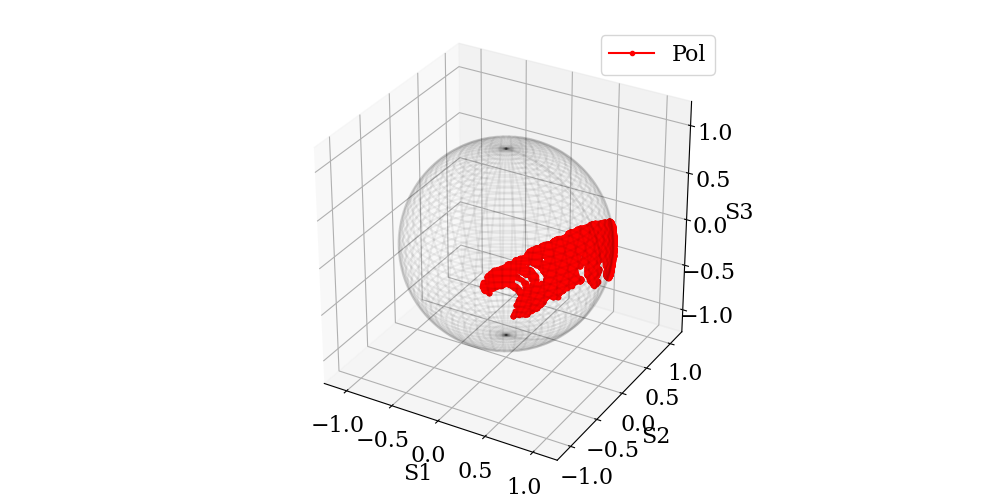

In [28]:
#read stokes paramter from file, used for later analysis

#read stokes paramter from file, used for later analysis
%matplotlib widget

import csv
from collections import defaultdict
import matplotlib.pyplot as plt
from pandas import *

#name=r"C:\Users\LABUSERS\Documents\Thorlabs\PAX1000\Sample_SM2m_0320_2am_5pm.csv"
name=r"Z:\AdvancedInterconnects\Qingjun\phase compensation\SM fiber strecther_thermal\PAX\0817_PAX_45c_50c_0.1c_10min.csv"

print(name)
from pandas import *
data = read_csv(name,encoding= 'unicode_escape')

Stokes1= data[' Normalized s 1 '].tolist()
Stokes2= data[' Normalized s 2 '].tolist()
Stokes3= data[' Normalized s 3 '].tolist()
S0= data[' S 0 [mW]'].tolist()


## sphere wireframe
diameter_sphere = 1
theta, phi = np.meshgrid(np.linspace(0, 2*np.pi, 100), np.linspace(0, np.pi, 100))
x_sphere, y_sphere, z_sphere = np.sin(phi)*np.cos(theta), np.sin(phi)*np.sin(theta), np.cos(phi)

figHandler = plt.figure()
axHandler = figHandler.add_subplot(111, projection='3d')
axHandler.plot(Stokes1[0:], Stokes2[0:], Stokes3[0:], '.-r', label='Pol')
axHandler.plot_wireframe(diameter_sphere*x_sphere, diameter_sphere*y_sphere, diameter_sphere*z_sphere, color='k', alpha=0.05)

axHandler.set_xlim([-1.2, 1.2]); axHandler.set_ylim([-1.2, 1.2]); axHandler.set_zlim([-1.2, 1.2])
axHandler.set_xlabel('S1'); axHandler.set_ylabel('S2'); axHandler.set_zlabel('S3')
axHandler.set_box_aspect([1, 1, 1])
plt.legend(); plt.show()

### DAQ(s) manual output

In [ ]:
%matplotlib inline

import os
import csv
import time
import psutil
import pyvisa
import random
import asyncio
import threading
import numpy as np
import pandas as pd
import nidaqmx as ni
from ctypes import *
from nidaqmx import constants
import ipywidgets as widgets
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.autolayout'] = True; plt.rc('font', size=16)
plt.rc('text', usetex=False); plt.rc('font', family='serif'); plt.rcParams['figure.figsize'] = (10, 5)

## init params
resMan = pyvisa.ResourceManager()
outputMain = widgets.Output()

if len(resMan.list_resources()) > 1: 
    instAddress = list(resMan.list_resources())[0] ## ignore if nothing found, can "simulate" from personal laptop
instHandler = 'None'
connStatus = 'Idle'

## classes
class Stacks(list):
    def __init__(self, maxSize):
        super().__init__()
        self.maxSize = maxSize

    def init(self, element):
        for i in range(self.maxSize):
            self.append(element)

    def push(self, element):
        self.append(element)
    
    def append(self, element):
        super().append(element)
        if super().__len__() > self.maxSize:
            super().__delitem__(0)

## init widgets
scanButton = widgets.Button(description='Scan for Instruments'); 
checkConnectButton = widgets.Button(description='Check Connection')
connectInstMeasButton = widgets.Button(description='Connect'); 
stopMeasButton = widgets.Button(description='Stop & Disconnect')
instIDBox = widgets.Text(); 
dropdownBox = widgets.Dropdown(options=list(resMan.list_resources()), description='Address')

## scan and connect
scanConnectButtonHandler = widgets.HBox([scanButton, checkConnectButton])
instFindHandler = widgets.VBox([scanConnectButtonHandler, dropdownBox])
instStartHandler = widgets.VBox([instIDBox, widgets.HBox([connectInstMeasButton, stopMeasButton])])

## first accordion 
DAQ1BoxConn = widgets.Text(description='DAQ1 Status', value='Not Connected', style={'description_width':'initial'}); DAQ2BoxConn = widgets.Text(description='DAQ 2 Status', value='Not Connected', style={'description_width':'initial'})
DAQ1AddrBox = widgets.IntText(description='DAQ1 Address [devX]', value=2, style={'description_width':'initial'}); DAQ2AddrBox = widgets.IntText(description='DAQ 2 Address [devX]', value=3, style={'description_width':'initial'})
DAQ1ConnButton = widgets.Button(description='Connect DAQ1', style={'description_width':'initial'}); DAQ2ConnButton = widgets.Button(description='Connect DAQ 2', style={'description_width':'initial'})
DAQ1AO0Slider = widgets.FloatSlider(description='DAQ1 AO0 [V]', value=0, min=-10, max=10, step=0.01, continuous_update=True, readout=True, disabled=True, style={'description_width':'initial'}); DAQ1AO1Slider = widgets.FloatSlider(description='DAQ1 AO1 [V]', value=0, min=-10, max=10, step=0.01, continuous_update=True, readout=True, disabled=True, style={'description_width':'initial'}); 
DAQ2AO0Slider = widgets.FloatSlider(description='DAQ2 AO0 [V]', value=0, min=-10, max=10, step=0.01, continuous_update=True, readout=True, disabled=True, style={'description_width':'initial'}); DAQ2AO1Slider = widgets.FloatSlider(description='DAQ2 AO1 [V]', value=0, min=-10, max=10, step=0.01, continuous_update=True, readout=True, disabled=True, style={'description_width':'initial'}); 
multiDAQLogBox = widgets.Textarea(layout=widgets.Layout(height='100px', width='100%'))

multiDAQHandler = widgets.VBox([widgets.HBox([DAQ1BoxConn, DAQ2BoxConn, DAQ1ConnButton]),
                                widgets.HBox([DAQ1AddrBox, DAQ2AddrBox, DAQ2ConnButton]),
                                widgets.HBox([DAQ1AO0Slider, DAQ2AO0Slider]),
                                widgets.HBox([DAQ1AO1Slider, DAQ2AO1Slider]),
                            multiDAQLogBox
                            ])

## all accordion
AccordHandler = widgets.Accordion(children=[multiDAQHandler])
AccordHandler.set_title(0, 'MultiDAQ')

## display widgets
display(
    widgets.VBox([widgets.Label('AdvancedInterconnect: Optimized for MultiDAQ'),
        widgets.HBox([instFindHandler, instStartHandler]),
        AccordHandler]), 
    outputMain)

## functions & classes
def logInBox(textbox, message):
    textbox.value = str(datetime.now()) + '   ' + message + '\n' + textbox.value

## handlers
def scanButtonHandler(value):
    with outputMain:
        dropdownBox.options = list(resMan.list_resources())
        print(str(datetime.now()) + '   Scanning for instruments...')
scanButton.on_click(scanButtonHandler)

def dropdownBoxHandler(value):
    global instAddress
    if value['type'] == 'change' and value['name'] == 'value':
        with outputMain:
            instAddress = value['new']
            print(str(datetime.now()) + '   Selected device address: ' + instAddress)
dropdownBox.observe(dropdownBoxHandler)

def checkConnectButtonHandler(value):
    global instHandler, instAddress
    with outputMain:
        connectInstMeasButton.disabled = True
        print(str(datetime.now()) + '   Connecting to: ' + instAddress)
        instHandler = resMan.open_resource(instAddress)
        instIDBox.value = instHandler.query('*IDN?').strip()
        print(str(datetime.now()) + '   Connected to: ' + instIDBox.value)
        connectInstMeasButton.disabled = False
checkConnectButton.on_click(checkConnectButtonHandler)

def connectInstButtonHandler(value):
    global instHandler
    with outputMain:
        if instIDBox.value != '':
                instHandler = resMan.open_resource(instAddress)
                print(str(datetime.now()) + '   Connection established to: ' + instIDBox.value); instIDBox.value = ''
        else:
            instIDBox.value = 'Check connection first!'
connectInstMeasButton.on_click(connectInstButtonHandler)

def stopMeasButtonHandler(value):
    global instHandler, DAQ1Handler, DAQ2Handler
    with outputMain:
        print(str(datetime.now()) + '   Ending measurements...')
        instIDBox.value = ''
        instHandler = 'None'; DAQ1Handler = 'None'; DAQ2Handler = 'None'

        DAQ1BoxConn.value = 'Not Connected'; DAQ2BoxConn.value = 'Not Connected'
        print(str(datetime.now()) + '   Device(s) disconnected.')
        stopEvent.set()
        print(str(datetime.now()) + '   Everything is stopped. Rerun the file to start again.')
stopMeasButton.on_click(stopMeasButtonHandler)

def DAQ1ConnButtonHandler(value):
    global DAQ1AO0Handler, DAQ1AO1Handler
    with outputMain:
        if DAQ1BoxConn.value == 'Not Connected':
            connStatus = 'Connecting'
            # connect to NI DAQ
            DAQ1AO0Handler = ni.Task(); DAQ1AO1Handler = ni.Task()
            DAQ1AO0Handler.ao_channels.add_ao_voltage_chan('dev'+str(DAQ1AddrBox.value)+'/ao0', min_val=-10, max_val=10)
            DAQ1AO1Handler.ao_channels.add_ao_voltage_chan('dev'+str(DAQ1AddrBox.value)+'/ao1', min_val=-10, max_val=10)

            DAQ1AO0Slider.value = 0; DAQ1AO1Slider.value = 0
            DAQ1AO0Slider.disabled = False; DAQ1AO1Slider.disabled = False

            instIDBox.value = 'DAQ1 connected!'
            logInBox(multiDAQLogBox, 'Connection established to DAQ1 and voltages set to [0,0]...')
            DAQ1BoxConn.value = 'Connected'; DAQ1ConnButton.description = 'Disconnect'
            connStatus = 'Idle'
        else:
            connStatus = 'Disconnecting'
            DAQ1AO0Slider.value = 0; DAQ1AO1Slider.value = 0
            # disconnect from NI DAQ
            DAQ1AO0Handler.stop(); DAQ1AO0Handler.close()
            DAQ1AO1Handler.stop(); DAQ1AO1Handler.close()
            DAQ1AO0Slider.disabled = True; DAQ1AO1Slider.disabled = True
            
            instIDBox.value = 'DAQ1 disconnected!'
            logInBox(multiDAQLogBox, 'DAQ1 disconnected successfully...')
            DAQ1BoxConn.value = 'Not Connected'; DAQ1ConnButton.description = 'Connect'
            connStatus = 'Idle'
DAQ1ConnButton.on_click(DAQ1ConnButtonHandler)

def DAQ2ConnButtonHandler(value):
    global DAQ2AO0Handler, DAQ2AO1Handler
    with outputMain:
        if DAQ2BoxConn.value == 'Not Connected':
            connStatus = 'Connecting'
            # connect to NI DAQ
            DAQ2AO0Handler = ni.Task(); DAQ2AO1Handler = ni.Task()
            DAQ2AO0Handler.ao_channels.add_ao_voltage_chan('dev'+str(DAQ2AddrBox.value)+'/ao0', min_val=-10, max_val=10)
            DAQ2AO1Handler.ao_channels.add_ao_voltage_chan('dev'+str(DAQ2AddrBox.value)+'/ao1', min_val=-10, max_val=10)

            DAQ2AO0Slider.value = 0; DAQ2AO1Slider.value = 0
            DAQ2AO0Slider.disabled = False; DAQ2AO1Slider.disabled = False

            instIDBox.value = 'DAQ2 connected!'
            logInBox(multiDAQLogBox, 'Connection established to DAQ2 and voltages set to [0,0]...')
            DAQ2BoxConn.value = 'Connected'; DAQ2ConnButton.description = 'Disconnect'
            connStatus = 'Idle'
        else:
            connStatus = 'Disconnecting'
            DAQ2AO0Slider.value = 0; DAQ2AO1Slider.value = 0
            # disconnect from NI DAQ
            DAQ2AO0Handler.stop(); DAQ2AO0Handler.close()
            DAQ2AO1Handler.stop(); DAQ2AO1Handler.close()
            DAQ2AO0Slider.disabled = True; DAQ2AO1Slider.disabled = True
            
            instIDBox.value = 'DAQ2 disconnected!'
            logInBox(multiDAQLogBox, 'DAQ2 disconnected successfully...')
            DAQ2BoxConn.value = 'Not Connected'; DAQ2ConnButton.description = 'Connect'
            connStatus = 'Idle'
DAQ2ConnButton.on_click(DAQ2ConnButtonHandler)

def applyVoltDAQ(task, volt):
    task.write([volt], auto_start=True)

## slider handlers
def DAQ1AO0Fun(valueChanged): applyVoltDAQ(DAQ1AO0Handler, valueChanged.new)
DAQ1AO0Slider.observe(DAQ1AO0Fun, 'value')
def DAQ1AO1Fun(valueChanged): applyVoltDAQ(DAQ1AO1Handler, valueChanged.new)
DAQ1AO1Slider.observe(DAQ1AO1Fun, 'value')
def DAQ2AO0Fun(valueChanged): applyVoltDAQ(DAQ2AO0Handler, valueChanged.new)
DAQ2AO0Slider.observe(DAQ2AO0Fun, 'value')
def DAQ2AO1Fun(valueChanged): applyVoltDAQ(DAQ2AO1Handler, valueChanged.new)
DAQ2AO1Slider.observe(DAQ2AO1Fun, 'value')

## readout functions
def updateReadout(stopEvent):
    while True:
        if connStatus == 'Idle':
            time.sleep(0.1)

## threading
threadsHandler = []
stopEvent = threading.Event()
threadsHandler.append(threading.Thread(target=updateReadout, args=(stopEvent,)))

for i in threadsHandler:
    i.start()